In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_csv('./diabetes.csv')
print('dataset shape {}'.format(data.shape))
data.head()

dataset shape (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


先分類

In [ ]:
data.groupby("Outcome").size()

Outcome
0    500
1    268
dtype: int64

In [ ]:
X = data.iloc[:, 0:8]
Y = data.iloc[:, 8]
print('shape of X {}; shape of Y {}'.format(X.shape, Y.shape))

shape of X (768, 8); shape of Y (768,)


拆解出80%當作訓練, 留下20%當測驗, 改test_size即可改動測驗用的比率, 相對地訓練用比率就降低; 可是調整要小心! 太少訓練資料會overfit

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

kNN通常可分三類 :
1. 正常, 也就是看均值
2. 有加權的, 距離越遠加權越小
3. 用半徑看
一般來說最好不要太依賴同一個模型, 是多個相關模型一起跑來看哪個好

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
models = []
models.append(("KNN", KNeighborsClassifier(n_neighbors=2)))
models.append(("KNN加權", KNeighborsClassifier(
    n_neighbors=2, weights="distance")))
models.append(("半徑內的鄰居", RadiusNeighborsClassifier(
    n_neighbors=2, radius=500.0)))
results = []
for name, model in models:
    model.fit(X_train, Y_train)
    results.append((name, model.score(X_test, Y_test)))
for i in range(len(results)):
    print("name: {}; score: {}".format(results[i][0],results[i][1]))

name: KNN; score: 0.7142857142857143
name: KNN加權; score: 0.6948051948051948
name: 半徑內的鄰居; score: 0.6233766233766234


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:467: FutureWarning: Passing additional keyword parameters has no effect and is deprecated in 1.0. An error will be raised from 1.2 and beyond. The ignored keyword parameter(s) are: dict_keys(['n_neighbors']).
  FutureWarning,


雖然正常kNN很高, 但因為隨機分配的關係, 應該要多次隨機分配訓練數據, 然後和交叉驗證才求模型準確與否評分的均值
以下取九次平均的訓練, 再看一次的測驗

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

results = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_result = cross_val_score(model, X, Y, cv=kfold)
    results.append((name, cv_result))
for i in range(len(results)):
    print("name: {}; cross val score: {}".format(
        results[i][0],results[i][1].mean()))

name: KNN; cross val score: 0.7147641831852358
name: KNN加權; cross val score: 0.6770505809979495
name: 半徑內的鄰居; cross val score: 0.6497265892002735


看排行還是正常kNN高, 用kNN來做預測

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, Y_train)
train_score = knn.score(X_train, Y_train)
test_score = knn.score(X_test, Y_test)
print("訓練得分: {}; 測驗得分: {}".format(train_score, test_score))

訓練得分: 0.8420195439739414; 測驗得分: 0.7142857142857143


kNN的效果看來對於原始資料在未適應的情況下很差, 這也表示預處理其實在很多時候有用

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

<Figure size 720x432 with 0 Axes>

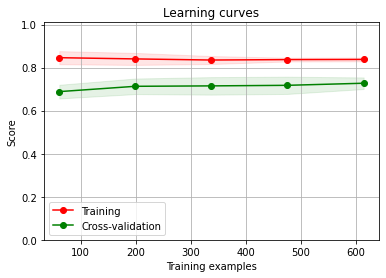

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel("Training examples")
  plt.ylabel("Score")
  train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
  plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training")
  plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation")
  plt.legend(loc="best")
  return plt

knn = KNeighborsClassifier(n_neighbors=2)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plt.figure(figsize=(10, 6))
plot_learning_curve(knn, "Learning curves", X, Y, (0.0, 1.01), cv=cv)

訓練樣本得分低、測試和訓練用的樣本差異過大; 迴歸或SVM可能能改善
看一下是不是特徵選取和數據可視化能看出端倪
透過SelectKBest求出相關性最大的兩個特徵(k=2)

In [ ]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(k=2)
X_new = selector.fit_transform(X, Y)
X_new[0:5]

array([[148. ,  33.6],
       [ 85. ,  26.6],
       [183. ,  23.3],
       [ 89. ,  28.1],
       [137. ,  43.1]])

看第一圖似乎血糖濃度、BMI比較有關, 只挑這兩項來訓練

In [ ]:
results = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_result = cross_val_score(model, X_new, Y, cv=kfold)
    results.append((name, cv_result))
for i in range(len(results)):
    print("演算方法: {}; 交互驗證得分: {}".format(results[i][0],results[i][1].mean()))

演算方法: KNN; 交互驗證得分: 0.7226076555023924
演算方法: KNN加權; 交互驗證得分: 0.6900375939849623
演算方法: 半徑內的鄰居; 交互驗證得分: 0.6510252904989747


一樣是正常kNN得分高, 用血糖濃度、BMI來繪製分布圖

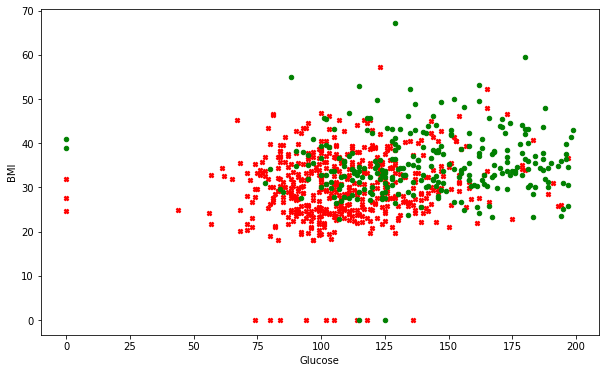

In [ ]:
plt.figure(figsize=(10, 6))
plt.ylabel("BMI")
plt.xlabel("Glucose")
plt.scatter(X_new[Y==0][:, 0], X_new[Y==0][:, 1], c='r', s=20, marker='X')
plt.scatter(X_new[Y==1][:, 0], X_new[Y==1][:, 1], c='g', s=20, marker='o')

由分布圖可看出中間數據密集, 這樣要是有資料剛好在中間數據區域就分不出來